# Image Classification

In this notebook will be performed image classification task on AneuRisk dataset. The images used are 3D reconstruction of the carotid artery from CAT images. The goal is to classify the aneurysm image as ruptured or unruptured.

Seven architectured will be tried. Firstly, through cross validation approach; secondly, through the train-validation-test approach, after performing data augmentation rotating the images by 20°.


In [1]:
# upload libraries
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from tensorflow import keras

import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle
import random

from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout
import tensorflow as tf
from tensorflow.keras.layers import concatenate
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from keras.preprocessing.image import ImageDataGenerator
import seaborn as sns

# Upload and Prepare data:

In [2]:
# drive connection
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# path for CV Approach
# images_path = "/content/drive/MyDrive/Images_AneuRisk/Arteries/"

In [3]:
# path for TRAIN-VALIDATION-TEST Approach
images_path = "/content/drive/MyDrive/Images_AneuRisk/Arteries_Rotated/"

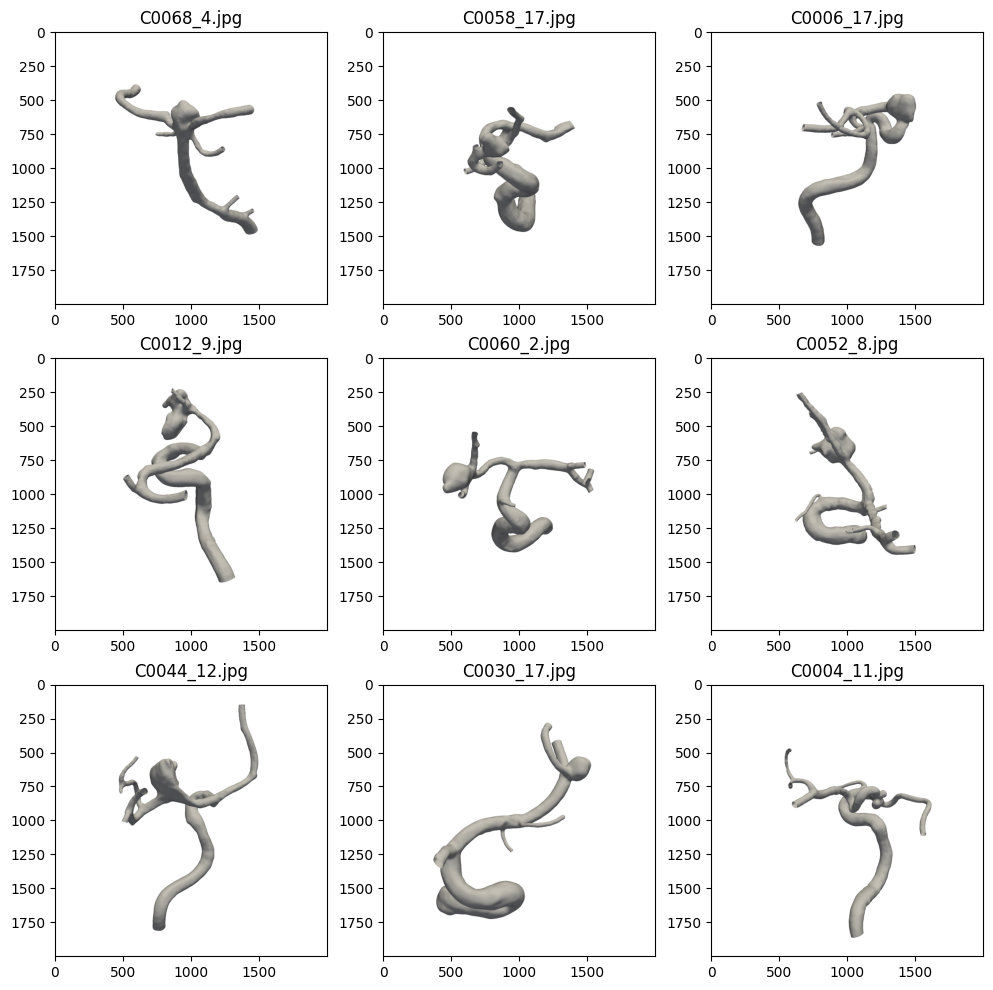

In [4]:
# plot some images
plt.figure(figsize=(12,12))
img = os.listdir(images_path)
to_plot = random.sample(img, 9)
for i in range(9):
    random_image = load_img(images_path + to_plot[i])
    plt.subplot(331 + i)
    plt.title(to_plot[i])
    plt.imshow(random_image)
plt.show()

In [5]:
# upload the images as 224x224 and check the shape to get the one for CNN
l = []
img = os.listdir(images_path)
for i in img:
  image = load_img(images_path + i, target_size=(224,224))
  image = np.array(image)
  reshaped_img = image.reshape(1,224,224,3)
  l.append([i[:5], reshaped_img])
print(reshaped_img.shape)

(1, 224, 224, 3)


In [6]:
# create the dataframe
df = pd.DataFrame(l, columns = ['ID_patient', 'image_array'])

In [7]:
# see the dataframe
df

,ID_patient,image_array
0,C0041,"[[[[255 255 255], [255 255 255], [255 255 255]..."
1,C0040,"[[[[255 255 255], [255 255 255], [255 255 255]..."
2,C0040,"[[[[255 255 255], [255 255 255], [255 255 255]..."
3,C0042,"[[[[255 255 255], [255 255 255], [255 255 255]..."
4,C0040,"[[[[255 255 255], [255 255 255], [255 255 255]..."
...,...,...
1719,C0039,"[[[[255 255 255], [255 255 255], [255 255 255]..."
1720,C0039,"[[[[255 255 255], [255 255 255], [255 255 255]..."
1721,C0042,"[[[[255 255 255], [255 255 255], [255 255 255]..."
1722,C0041,"[[[[255 255 255], [255 255 255], [255 255 255]..."


In [8]:
# create a patient list to order the dataframe
patient_list = []
for i in range(df.shape[0]):
  n = int(df['ID_patient'][i][1:])
  patient_list.append(n)

In [9]:
# associate the patient_list to the dataframe
df['patient_number'] = patient_list
df

,ID_patient,image_array,patient_number
0,C0041,"[[[[255 255 255], [255 255 255], [255 255 255]...",41
1,C0040,"[[[[255 255 255], [255 255 255], [255 255 255]...",40
2,C0040,"[[[[255 255 255], [255 255 255], [255 255 255]...",40
3,C0042,"[[[[255 255 255], [255 255 255], [255 255 255]...",42
4,C0040,"[[[[255 255 255], [255 255 255], [255 255 255]...",40
...,...,...,...
1719,C0039,"[[[[255 255 255], [255 255 255], [255 255 255]...",39
1720,C0039,"[[[[255 255 255], [255 255 255], [255 255 255]...",39
1721,C0042,"[[[[255 255 255], [255 255 255], [255 255 255]...",42
1722,C0041,"[[[[255 255 255], [255 255 255], [255 255 255]...",41


In [10]:
# order the dataframe
df = df.sort_values('patient_number')
df = df.reset_index()
df = df.drop(['patient_number', 'index'], axis = 1)

In [11]:
# read the dataframe with generalities
feature_df = pd.read_csv("/content/drive/MyDrive/THESIS/dataset.csv")
feature_df

,id,institution,modality,age,sex,aneurysmType,aneurysmLocation,ruptureStatus,multipleAneurysms,medicalIstory
0,C0001,NiguardaHospitalMilan,3D-RA,53,F,LAT,ICA,U,False,NaN
1,C0002,NiguardaHospitalMilan,3D-RA,35,F,LAT,ICA,U,False,NaN
2,C0003,NiguardaHospitalMilan,3D-RA,43,F,TER,ICA,U,False,NaN
3,C0004,NiguardaHospitalMilan,3D-RA,60,F,TER,ICA,U,True,NaN
4,C0005,NiguardaHospitalMilan,3D-RA,26,F,LAT,ICA,R,False,NaN
...,...,...,...,...,...,...,...,...,...,...
90,C0095,NiguardaHospitalMilan,3D-RA,43,F,TER,BAS,F,False,NaN
91,C0096,NiguardaHospitalMilan,3D-RA,67,M,TER,BAS,R,False,NaN
92,C0097,NiguardaHospitalMilan,3D-RA,84,F,LAT,ICA,R,False,NaN
93,C0098,NiguardaHospitalMilan,3D-RA,59,F,TER,MCA,R,False,NaN


In [12]:
# drop the wrong inserted patient
feature_df = feature_df.drop(feature_df[feature_df.ruptureStatus =='F'].index, axis = 0)

In [13]:
# look at the dataframe
feature_df

,id,institution,modality,age,sex,aneurysmType,aneurysmLocation,ruptureStatus,multipleAneurysms,medicalIstory
0,C0001,NiguardaHospitalMilan,3D-RA,53,F,LAT,ICA,U,False,NaN
1,C0002,NiguardaHospitalMilan,3D-RA,35,F,LAT,ICA,U,False,NaN
2,C0003,NiguardaHospitalMilan,3D-RA,43,F,TER,ICA,U,False,NaN
3,C0004,NiguardaHospitalMilan,3D-RA,60,F,TER,ICA,U,True,NaN
4,C0005,NiguardaHospitalMilan,3D-RA,26,F,LAT,ICA,R,False,NaN
...,...,...,...,...,...,...,...,...,...,...
89,C0094,NiguardaHospitalMilan,3D-RA,36,F,TER,MCA,R,False,NaN
91,C0096,NiguardaHospitalMilan,3D-RA,67,M,TER,BAS,R,False,NaN
92,C0097,NiguardaHospitalMilan,3D-RA,84,F,LAT,ICA,R,False,NaN
93,C0098,NiguardaHospitalMilan,3D-RA,59,F,TER,MCA,R,False,NaN


In [14]:
# remove wrong inserted patient also from df
df = df.drop(df[df.ID_patient == 'C0095'].index, axis = 0)

In [15]:
# associate to df the target variable - R/U
target = []
for i in df['ID_patient'].tolist():
  target.append(feature_df[feature_df.id == i]['ruptureStatus'].values[0])

In [16]:
# associate the variable to dataframe column
df['Target'] = target

In [17]:
# R = 1, U = 0
df['Target_binary'] = pd.get_dummies(df['Target']).iloc[:, 0]

# Define Epoch and Batch Size

In [18]:
# define epoch and batch size
n_epoch = 50
batch = 64

# VGG16

Let's start with the first architecture.

In [19]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

In [20]:
# upload the base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [21]:
# freeze the weights
for layer in base_model.layers:
    layer.trainable = False

In [22]:
# create the X array and the Y dummy variable
Y = pd.get_dummies(df['Target']).values
X = df['image_array'].to_numpy()
X = np.concatenate(X, axis = 0)

In [23]:
# build the architecture
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001), loss='binary_crossentropy', metrics=['accuracy'])

## Train and Test:

In [24]:
# split train / test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)
# split train / validation
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.3, random_state = 42)

In [25]:
# see the shape
print(f'X shape: {X_val.shape}  Y shape: {Y_val.shape}')

X shape: (410, 224, 224, 3)  Y shape: (410, 2)


Data Augmentation:

In [26]:
# perform data augmentation
datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.1,
    samplewise_std_normalization = True,
    brightness_range = [0.1, 0.5]
)

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1469: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn(


Fit:

In [27]:
# set up batch size and number of epochs
batch_size = batch
epochs = n_epoch

# checkpoint
checkpoint = ModelCheckpoint(f'best_vgg16_traintest.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

# fit the model
model.fit(
    datagen.flow(X_train, Y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=(X_val, Y_val),
    callbacks = [checkpoint]
)

Epoch 1/50
14/14 [==============================] - ETA: 0s - loss: 1.9977 - accuracy: 0.5169
Epoch 1: val_loss improved from inf to 12.00504, saving model to best_vgg16_traintest.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 47s 2s/step - loss: 1.9977 - accuracy: 0.5169 - val_loss: 12.0050 - val_accuracy: 0.4561
Epoch 2/50
14/14 [==============================] - ETA: 0s - loss: 0.7756 - accuracy: 0.5379
Epoch 2: val_loss improved from 12.00504 to 1.53212, saving model to best_vgg16_traintest.h5
14/14 [==============================] - 18s 1s/step - loss: 0.7756 - accuracy: 0.5379 - val_loss: 1.5321 - val_accuracy: 0.4951
Epoch 3/50
14/14 [==============================] - ETA: 0s - loss: 0.6890 - accuracy: 0.5427
Epoch 3: val_loss improved from 1.53212 to 1.12731, saving model to best_vgg16_traintest.h5
14/14 [==============================] - 17s 1s/step - loss: 0.6890 - accuracy: 0.5427 - val_loss: 1.1273 - val_accuracy: 0.5585
Epoch 4/50
14/14 [==============================] - ETA: 0s - loss: 0.6788 - accuracy: 0.5831
Epoch 4: val_loss did not improve from 1.12731
14/14 [==============================] - 17s 1s/step - loss: 0.6788 - accuracy: 0.5831 - val_loss:

In [28]:
# compute validation accuracy
res = model.evaluate(X_val, Y_val)
accuracy_vgg16 = res[1]

13/13 [==============================] - 2s 121ms/step - loss: 3.9246 - accuracy: 0.6098


Make Predictions:

In [29]:
# make prediction on test set
predictions = model.predict(X_test)
pred_classes = np.argmax(predictions, axis = 1)
y_true = np.argmax(Y_test, axis = 1)

11/11 [==============================] - 5s 468ms/step


Confusion Matrix:

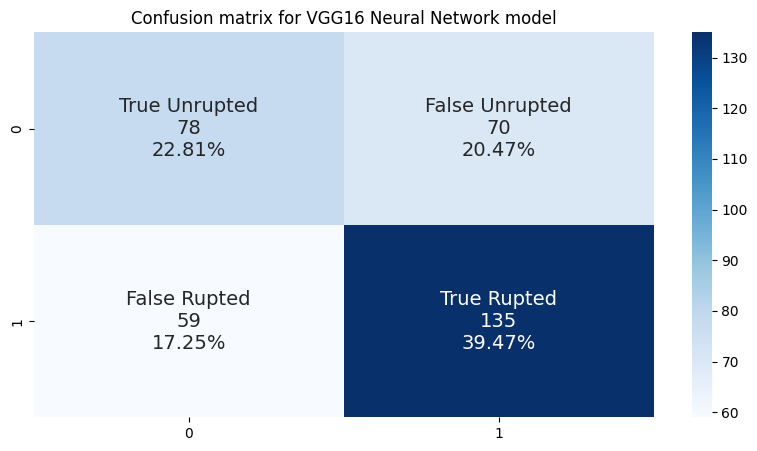

In [30]:
# build CONFUSION MATRIX

cf = confusion_matrix(y_true, pred_classes)

# Create labels
group_names = ['True Unrupted','False Unrupted','False Rupted','True Rupted']
group_counts = ["{0:0.0f}".format(value) for value in
                cf.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf.flatten()/np.sum(cf)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(10,5))
palette = sns.color_palette("Blues", as_cmap=True)
sns.heatmap(cf,
            annot=labels,
            fmt='',
            annot_kws={
                'fontsize': 14,
            },
            cmap=palette)
plt.title('Confusion matrix for VGG16 Neural Network model')
plt.show()

In [31]:
# compute test accuracy
accuracy_test_vgg16 = accuracy_score(pred_classes, y_true)
accuracy_test_vgg16

0.6228070175438597

## Cross Validation:

In [ ]:
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical

In [ ]:
# stratify the dataset into 8 folders
skf = StratifiedKFold(n_splits=8, shuffle = True, random_state=42)

In [ ]:
# convert the Y as dummy
Y = pd.get_dummies(df['Target']).iloc[:, 0].to_numpy()

In [ ]:
# perform CV

# set the best accuracy
best_accuracy = 0
# create fold accuracies list
fold_accuracies_vgg16 = []
# set the batch size
batch_size = batch
# set the number of epochs
epoch = n_epoch

for fold_number, (train_index, val_index) in enumerate(skf.split(X, Y), start = 1):
    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = Y[train_index], Y[val_index]

    # perform data augmentation
    datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.1,
    samplewise_std_normalization = True,
    brightness_range = [0.1, 0.5])

    # convert y_train_fold and y_val_fold to one-hot encoded form
    y_train_fold_encoded = to_categorical(y_train_fold, num_classes=2, dtype= 'int')
    y_val_fold_encoded = to_categorical(y_val_fold, num_classes=2, dtype= 'int')

    # checkpoint
    checkpoint = ModelCheckpoint(f'bestCV_vgg16_{fold_number}.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

    # early stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True
    )

    # fit the model
    model.fit(
        datagen.flow(X_train_fold, y_train_fold_encoded, batch_size=batch_size),
        steps_per_epoch=len(X_train_fold) // batch_size,
        epochs=epoch,
        validation_data=(X_val_fold, y_val_fold_encoded),
        callbacks = [checkpoint, early_stopping]
    )

    # compute validation accuracy
    results = model.evaluate(X_val_fold, y_val_fold_encoded)
    # create the list of fold accuracies
    fold_accuracy = results[1]
    fold_accuracies_vgg16.append(fold_accuracy)

    # save the best validation accuracy value
    if fold_accuracy > best_accuracy:
        best_accuracy = fold_accuracy
        model.save('bestCV_vgg19.h5')

# see results
print("Fold Accuracies:", fold_accuracies_vgg16)

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1469: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn(


Epoch 1/50
10/10 [==============================] - ETA: 0s - loss: 1.8988 - accuracy: 0.5270
Epoch 1: val_loss improved from inf to 31.72917, saving model to bestCV_vgg16_1.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 16s 546ms/step - loss: 1.8988 - accuracy: 0.5270 - val_loss: 31.7292 - val_accuracy: 0.5833
Epoch 2/50
10/10 [==============================] - ETA: 0s - loss: 1.9988 - accuracy: 0.5270
Epoch 2: val_loss did not improve from 31.72917
10/10 [==============================] - 2s 182ms/step - loss: 1.9988 - accuracy: 0.5270 - val_loss: 49.4360 - val_accuracy: 0.5833
Epoch 3/50
10/10 [==============================] - ETA: 0s - loss: 1.7382 - accuracy: 0.6081
Epoch 3: val_loss improved from 31.72917 to 19.12239, saving model to bestCV_vgg16_1.h5
10/10 [==============================] - 4s 388ms/step - loss: 1.7382 - accuracy: 0.6081 - val_loss: 19.1224 - val_accuracy: 0.5833
Epoch 4/50
10/10 [==============================] - ETA: 0s - loss: 1.1028 - accuracy: 0.5811
Epoch 4: val_loss did not improve from 19.12239
10/10 [==============================] - 5s 409ms/step - loss: 1.1028 - accuracy: 0.5811 - val_loss: 28.3715 - val_accuracy: 0.5833
Epoch

In [ ]:
# obtain the CV mean accuracy:
cv_mean_vgg16 = np.mean(fold_accuracies_vgg16)
cv_max_vgg16 = max(fold_accuracies_vgg16)
print('Mean CV: ', cv_mean_vgg16, '\nMax CV: ', cv_max_vgg16)

Mean CV:  0.6183712109923363 
Max CV:  0.7272727489471436


# VGG19

Second architecture.

In [32]:
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input

In [33]:
# upload the base model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

80134624/80134624 [==============================] - 0s 0us/step


In [34]:
# freeze the weights
for layer in base_model.layers:
    layer.trainable = False

In [35]:
# create the X array and the Y dummy variable
Y = pd.get_dummies(df['Target']).values
X = df['image_array'].to_numpy()
X = np.concatenate(X, axis = 0)

In [36]:
# build the architecture with base model VGG19
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001), loss='binary_crossentropy', metrics=['accuracy'])

## Train and Test

In [37]:
# split train / test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1, random_state = 42)
# split train / validation
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.3, random_state = 42)

In [38]:
# check the shape
print(f'X shape: {X_val.shape}  Y shape: {Y_val.shape}')

X shape: (461, 224, 224, 3)  Y shape: (461, 2)


Data Augmentation:

In [39]:
# perform data augmentation to avoid overfitting and increase dataset size

datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    samplewise_std_normalization = True,
    brightness_range = [0.1, 0.7]
)

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1469: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn(


Fit:

In [40]:
# set up batch size and number of epochs
batch_size = batch
epochs = n_epoch

# checkpoint
checkpoint = ModelCheckpoint(f'best_vgg19_traintest.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

# fit the model
model.fit(
    datagen.flow(X_train, Y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=(X_val, Y_val),
    callbacks = [checkpoint, early_stopping]
)

Epoch 1/50
16/16 [==============================] - ETA: 0s - loss: 1.6817 - accuracy: 0.5257
Epoch 1: val_loss improved from inf to 3.19358, saving model to best_vgg19_traintest.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 29s 2s/step - loss: 1.6817 - accuracy: 0.5257 - val_loss: 3.1936 - val_accuracy: 0.6312
Epoch 2/50
16/16 [==============================] - ETA: 0s - loss: 0.7094 - accuracy: 0.5475
Epoch 2: val_loss improved from 3.19358 to 1.84039, saving model to best_vgg19_traintest.h5
16/16 [==============================] - 19s 1s/step - loss: 0.7094 - accuracy: 0.5475 - val_loss: 1.8404 - val_accuracy: 0.6030
Epoch 3/50
16/16 [==============================] - ETA: 0s - loss: 0.6883 - accuracy: 0.5436
Epoch 3: val_loss did not improve from 1.84039
16/16 [==============================] - 18s 1s/step - loss: 0.6883 - accuracy: 0.5436 - val_loss: 2.0266 - val_accuracy: 0.5770
Epoch 4/50
16/16 [==============================] - ETA: 0s - loss: 0.6827 - accuracy: 0.5485
Epoch 4: val_loss did not improve from 1.84039
16/16 [==============================] - 18s 1s/step - loss: 0.6827 - accuracy: 0.5485 - val_loss: 3.0215 - val_accuracy: 0.5705
Epoch 5/50
16/16

In [41]:
# evaluate accuracy on the validation set
res = model.evaluate(X_val, Y_val)
accuracy_vgg19 = res[1]

15/15 [==============================] - 2s 141ms/step - loss: 2.1314 - accuracy: 0.6247


Make predictions:

In [42]:
# make predictions
predictions = model.predict(X_test)
pred_classes = np.argmax(predictions, axis = 1)
y_true = np.argmax(Y_test, axis = 1)

6/6 [==============================] - 4s 579ms/step


Confusion Matrix:

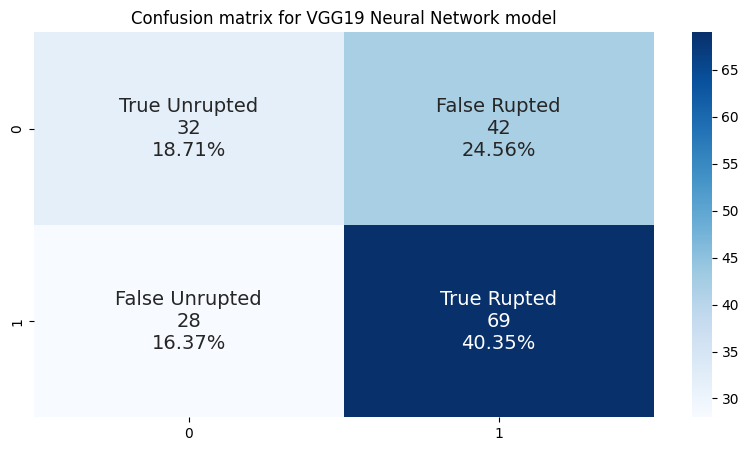

In [43]:
# build CONFUSION MATRIX

cf = confusion_matrix(y_true, pred_classes)
# create labels
group_names = ['True Unrupted','False Rupted','False Unrupted','True Rupted']
group_counts = ["{0:0.0f}".format(value) for value in
                cf.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf.flatten()/np.sum(cf)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(10,5))
palette = sns.color_palette("Blues", as_cmap=True)
sns.heatmap(cf,
            annot=labels,
            fmt='',
            annot_kws={
                'fontsize': 14,
            },
            cmap=palette)
plt.title('Confusion matrix for VGG19 Neural Network model')
plt.show()

In [44]:
# check the test accuracy
accuracy_test_vgg19 = accuracy_score(pred_classes, y_true)
accuracy_test_vgg19

0.5906432748538012

## Cross Validation

In [ ]:
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical

In [ ]:
# stratify the dataset into 8 folders
skf = StratifiedKFold(n_splits=8, shuffle = True, random_state=42)

In [ ]:
# convert the Y as dummy
Y = pd.get_dummies(df['Target']).iloc[:, 0].to_numpy()

In [ ]:
# perform CV

# set the best accuracy
best_accuracy = 0
# create the list of accuracies
fold_accuracies_vgg19 = []
# set the batch size
batch_size = batch
# set the number of epochs
epoch = n_epoch

for fold_number, (train_index, val_index) in enumerate(skf.split(X, Y), start = 1):
    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = Y[train_index], Y[val_index]

    # perform data augmentation
    datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.1,
    samplewise_std_normalization = True,
    brightness_range = [0.1, 0.5])

    # convert y_train_fold and y_val_fold to one-hot encoded form
    y_train_fold_encoded = to_categorical(y_train_fold, num_classes=2, dtype= 'int')
    y_val_fold_encoded = to_categorical(y_val_fold, num_classes=2, dtype= 'int')

    # set the checkpoint
    checkpoint = ModelCheckpoint(f'bestCV_vgg19_{fold_number}.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

    # early stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True
    )

    # fit the model
    model.fit(
        datagen.flow(X_train_fold, y_train_fold_encoded, batch_size=batch_size),
        steps_per_epoch=len(X_train_fold) // batch_size,
        epochs=epoch,
        validation_data=(X_val_fold, y_val_fold_encoded),
        callbacks = [checkpoint, early_stopping]
    )

    # evaluate the model and compute the accuracy
    results = model.evaluate(X_val_fold, y_val_fold_encoded)
    # append the accuracies values for each fold
    fold_accuracy = results[1]
    fold_accuracies_vgg19.append(fold_accuracy)

    if fold_accuracy > best_accuracy:
        best_accuracy = fold_accuracy
        model.save('bestCV_vgg19.h5')

# see the accuracies
print("Fold Accuracies:", fold_accuracies_vgg19)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1469: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn(


10/10 [==============================] - ETA: 0s - loss: 0.5567 - accuracy: 0.6750
Epoch 1: val_loss improved from inf to 12.61555, saving model to bestCV_vgg19_1.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 2s 190ms/step - loss: 0.5567 - accuracy: 0.6750 - val_loss: 12.6156 - val_accuracy: 0.6364
Epoch 2/50
10/10 [==============================] - ETA: 0s - loss: 0.5193 - accuracy: 0.7838
Epoch 2: val_loss did not improve from 12.61555
10/10 [==============================] - 1s 126ms/step - loss: 0.5193 - accuracy: 0.7838 - val_loss: 13.5298 - val_accuracy: 0.6364
Epoch 3/50
10/10 [==============================] - ETA: 0s - loss: 0.5592 - accuracy: 0.6757
Epoch 3: val_loss did not improve from 12.61555
10/10 [==============================] - 2s 205ms/step - loss: 0.5592 - accuracy: 0.6757 - val_loss: 14.5015 - val_accuracy: 0.5455
Epoch 4/50
10/10 [==============================] - ETA: 0s - loss: 0.5154 - accuracy: 0.7027
Epoch 4: val_loss did not improve from 12.61555
10/10 [==============================] - 2s 204ms/step - loss: 0.5154 - accuracy: 0.7027 - val_loss: 16.0299 - val_accuracy: 0.5455
Epoch 5/50
10/10 [============================

In [ ]:
# obtain the CV mean accuracy:
cv_mean_vgg19 = np.mean(fold_accuracies_vgg19)
cv_max_vgg19 = max(fold_accuracies_vgg19)
print('Mean CV: ', cv_mean_vgg19, '\nMax CV: ', cv_max_vgg19)

Mean CV:  0.6392045468091965 
Max CV:  0.7272727489471436


# ResNet50

Third Architecture.

In [45]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

In [46]:
# upload the base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 [==============================] - 0s 0us/step


In [47]:
# freeze the weights
for layer in base_model.layers:
    layer.trainable = False

In [48]:
# create the X array and the Y dummy variable
Y = pd.get_dummies(df['Target']).values
X = df['image_array'].to_numpy()
X = np.concatenate(X, axis = 0)

In [49]:
# build the architecture with base model ResNet50
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001), loss='binary_crossentropy', metrics=['accuracy'])

## Train and Test

In [51]:
# split train / test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)
# split train / validation
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.3, random_state = 42)

In [52]:
# see the shapes
print(f'X shape: {X_val.shape}  Y shape: {Y_val.shape}')

X shape: (410, 224, 224, 3)  Y shape: (410, 2)


Data Augmentation:

In [53]:
# perform data augmentation to avoid overfitting and increase dataset size

datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.1,
    samplewise_std_normalization = True,
    brightness_range = [0.1, 0.5]
)

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1469: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn(


Fit:

In [54]:
# set up batch size and number of epochs
batch_size = batch
epochs = n_epoch

# checkpoint
checkpoint = ModelCheckpoint(f'best_resnet50_traintest.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

# fit the model
model.fit(
    datagen.flow(X_train, Y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=(X_val, Y_val),
    callbacks = [checkpoint, early_stopping]
)

Epoch 1/50
14/14 [==============================] - ETA: 0s - loss: 8.8952 - accuracy: 0.5034
Epoch 1: val_loss improved from inf to 8.15922, saving model to best_resnet50_traintest.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 36s 2s/step - loss: 8.8952 - accuracy: 0.5034 - val_loss: 8.1592 - val_accuracy: 0.4537
Epoch 2/50
14/14 [==============================] - ETA: 0s - loss: 1.3450 - accuracy: 0.5056
Epoch 2: val_loss improved from 8.15922 to 0.70526, saving model to best_resnet50_traintest.h5
14/14 [==============================] - 22s 2s/step - loss: 1.3450 - accuracy: 0.5056 - val_loss: 0.7053 - val_accuracy: 0.5439
Epoch 3/50
14/14 [==============================] - ETA: 0s - loss: 0.7401 - accuracy: 0.5483
Epoch 3: val_loss improved from 0.70526 to 0.69523, saving model to best_resnet50_traintest.h5
14/14 [==============================] - 20s 1s/step - loss: 0.7401 - accuracy: 0.5483 - val_loss: 0.6952 - val_accuracy: 0.5439
Epoch 4/50
14/14 [==============================] - ETA: 0s - loss: 0.6960 - accuracy: 0.5461
Epoch 4: val_loss improved from 0.69523 to 0.69266, saving model to best_resnet50_traintest.h5
14/14 [==============================] - 17s 1

In [55]:
# see the accuracy on the validation set of the best and saved model
res = model.evaluate(X_val, Y_val)
accuracy_resnet50 = res[1]

13/13 [==============================] - 1s 94ms/step - loss: 0.6836 - accuracy: 0.5780


Model Predictions:

In [56]:
# predictions
predictions = model.predict(X_test)
pred_classes = np.argmax(predictions, axis = 1)
y_true = np.argmax(Y_test, axis = 1)

11/11 [==============================] - 3s 188ms/step


Confusion Matrix:

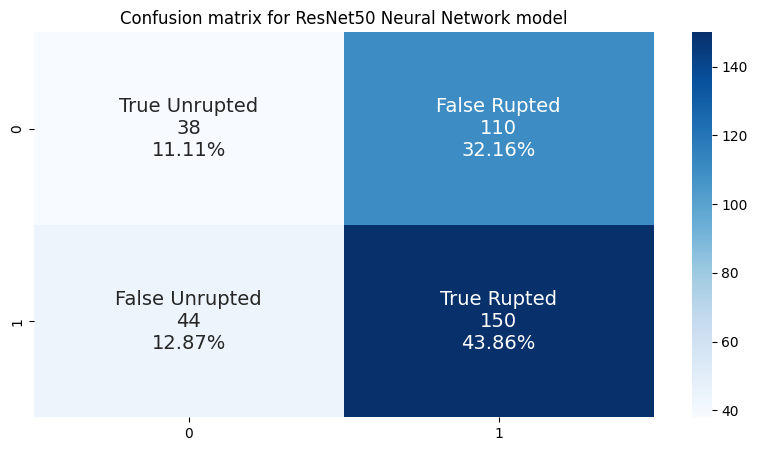

In [57]:
# create CONFUSION MATRIX

cf = confusion_matrix(y_true, pred_classes)
# create labels
group_names = ['True Unrupted','False Rupted','False Unrupted','True Rupted']
group_counts = ["{0:0.0f}".format(value) for value in
                cf.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf.flatten()/np.sum(cf)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(10,5))
palette = sns.color_palette("Blues", as_cmap=True)
sns.heatmap(cf,
            annot=labels,
            fmt='',
            annot_kws={
                'fontsize': 14,
            },
            cmap=palette)
plt.title('Confusion matrix for ResNet50 Neural Network model')
plt.show()

In [58]:
# see prediction accuracy
accuracy_test_resnet50 = accuracy_score(pred_classes, y_true)
accuracy_test_resnet50

0.5497076023391813

## Cross Validation

In [50]:
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical

In [ ]:
# stratify the dataset into 8 folders
skf = StratifiedKFold(n_splits=8, shuffle = True, random_state=42)

In [ ]:
# convert the Y as dummy
Y = pd.get_dummies(df['Target']).iloc[:, 0].to_numpy()

In [ ]:
# perform CV

# set best accuracy
best_accuracy = 0
# create a list to add CV accuracies
fold_accuracies_resnet50 = []
# set the batch size
batch_size = batch
# set the number of epochs
epoch = n_epoch

for fold_number, (train_index, val_index) in enumerate(skf.split(X, Y), start = 1):
    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = Y[train_index], Y[val_index]

    # perform data augmentation
    datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.1,
    samplewise_std_normalization = True,
    brightness_range = [0.1, 0.5])

    # convert y_train_fold and y_val_fold to one-hot encoded form
    y_train_fold_encoded = to_categorical(y_train_fold, num_classes=2, dtype= 'int')
    y_val_fold_encoded = to_categorical(y_val_fold, num_classes=2, dtype= 'int')

    # set the checkpoint
    checkpoint = ModelCheckpoint(f'bestCV_resnet50_{fold_number}.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

    # early stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True
    )

    # fit the model
    model.fit(
        datagen.flow(X_train_fold, y_train_fold_encoded, batch_size=batch_size),
        steps_per_epoch=len(X_train_fold) // batch_size,
        epochs=epoch,
        validation_data=(X_val_fold, y_val_fold_encoded),
        callbacks = [checkpoint, early_stopping]
    )

    # obtain the accuracies
    results = model.evaluate(X_val_fold, y_val_fold_encoded)
    # append accuracies to the list
    fold_accuracy = results[1]
    fold_accuracies_resnet50.append(fold_accuracy)

    # check the best accuracy
    if fold_accuracy > best_accuracy:
        best_accuracy = fold_accuracy
        model.save('bestCV_resnet50.h5')

# see results
print("Fold Accuracies:", fold_accuracies_resnet50)

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1469: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn(


Epoch 1/50
10/10 [==============================] - ETA: 0s - loss: 14.3990 - accuracy: 0.5135
Epoch 1: val_loss improved from inf to 12.77263, saving model to bestCV_resnet50_1.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 14s 655ms/step - loss: 14.3990 - accuracy: 0.5135 - val_loss: 12.7726 - val_accuracy: 0.5833
Epoch 2/50
10/10 [==============================] - ETA: 0s - loss: 11.1538 - accuracy: 0.6351
Epoch 2: val_loss improved from 12.77263 to 5.30285, saving model to bestCV_resnet50_1.h5
10/10 [==============================] - 8s 862ms/step - loss: 11.1538 - accuracy: 0.6351 - val_loss: 5.3029 - val_accuracy: 0.6667
Epoch 3/50
10/10 [==============================] - ETA: 0s - loss: 9.2825 - accuracy: 0.5541
Epoch 3: val_loss did not improve from 5.30285
10/10 [==============================] - 1s 129ms/step - loss: 9.2825 - accuracy: 0.5541 - val_loss: 9.6019 - val_accuracy: 0.4167
Epoch 4/50
10/10 [==============================] - ETA: 0s - loss: 7.0302 - accuracy: 0.5270
Epoch 4: val_loss did not improve from 5.30285
10/10 [==============================] - 2s 186ms/step - loss: 7.0302 - accuracy: 0.5270 - val_loss: 11.1037 - val_accuracy: 0.5000
Epoc

In [ ]:
# obtain the CV mean accuracy:
cv_mean_resnet50 = np.mean(fold_accuracies_resnet50)
cv_max_resnet50 = max(fold_accuracies_resnet50)
print('Mean CV: ', cv_mean_resnet50, '\nMax CV: ', cv_max_resnet50)

Mean CV:  0.6268939450383186 
Max CV:  0.8333333134651184


# ResNet V2

Fourth Architecture.

In [59]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input

In [60]:
# upload the base model
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94668760/94668760 [==============================] - 0s 0us/step


In [61]:
# freeze the weights
for layer in base_model.layers:
    layer.trainable = False

In [62]:
# create the X array of images and the dummy variable Y
Y = pd.get_dummies(df['Target']).values
X = df['image_array'].to_numpy()
X = np.concatenate(X, axis = 0)

In [63]:
# build the architecture with base model ResNet50V2
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

## Train and Test

In [64]:
# split train / test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)
# split train / validation
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.3, random_state = 42)

In [65]:
# check the shapes
print(f'X shape: {X_val.shape}  Y shape: {Y_val.shape}')

X shape: (410, 224, 224, 3)  Y shape: (410, 2)


Data Augmentation:

In [66]:
# perform data augmentation to avoid overfitting and increase dataset size

datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.1,
    samplewise_std_normalization = True,
    brightness_range = [0.1, 0.5]
)

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1469: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn(


Fit:

In [67]:
# set up batch size and number of epochs
batch_size = batch
epochs = n_epoch

# checkpoint
checkpoint = ModelCheckpoint(f'best_resnet50V2_traintest.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

# fit the model
model.fit(
    datagen.flow(X_train, Y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=(X_val, Y_val),
    callbacks = [checkpoint, early_stopping]
)

Epoch 1/50
14/14 [==============================] - ETA: 0s - loss: 359.5194 - accuracy: 0.5169
Epoch 1: val_loss improved from inf to 2078.40039, saving model to best_resnet50V2_traintest.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 33s 2s/step - loss: 359.5194 - accuracy: 0.5169 - val_loss: 2078.4004 - val_accuracy: 0.4537
Epoch 2/50
14/14 [==============================] - ETA: 0s - loss: 15.4951 - accuracy: 0.5146
Epoch 2: val_loss improved from 2078.40039 to 53.26668, saving model to best_resnet50V2_traintest.h5
14/14 [==============================] - 26s 2s/step - loss: 15.4951 - accuracy: 0.5146 - val_loss: 53.2667 - val_accuracy: 0.4537
Epoch 3/50
14/14 [==============================] - ETA: 0s - loss: 1.1471 - accuracy: 0.5483
Epoch 3: val_loss improved from 53.26668 to 0.69137, saving model to best_resnet50V2_traintest.h5
14/14 [==============================] - 21s 2s/step - loss: 1.1471 - accuracy: 0.5483 - val_loss: 0.6914 - val_accuracy: 0.5463
Epoch 4/50
14/14 [==============================] - ETA: 0s - loss: 0.8004 - accuracy: 0.5438
Epoch 4: val_loss improved from 0.69137 to 0.69053, saving model to best_resnet50V2_traintest.h5
14/14 [====================

In [68]:
# see the accuracy of the best and saved model
res = model.evaluate(X_val, Y_val)
accuracy_resnetv2 = res[1]

13/13 [==============================] - 1s 88ms/step - loss: 0.6888 - accuracy: 0.5463


Model Predictions:

In [69]:
# predictions
predictions = model.predict(X_test)
pred_classes = np.argmax(predictions, axis = 1)
y_true = np.argmax(Y_test, axis = 1)

11/11 [==============================] - 2s 155ms/step


Confusion Matrix:

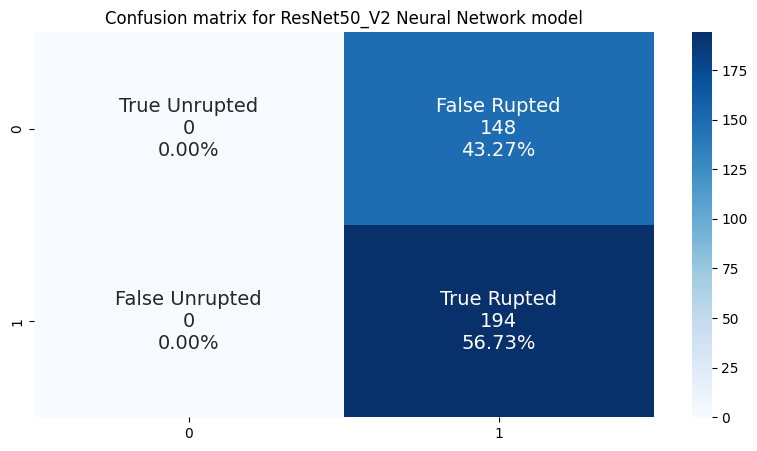

In [70]:
# create CONFUSION MATRIX

cf = confusion_matrix(y_true, pred_classes)
# create labels
group_names = ['True Unrupted','False Rupted','False Unrupted','True Rupted']
group_counts = ["{0:0.0f}".format(value) for value in
                cf.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf.flatten()/np.sum(cf)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(10,5))
palette = sns.color_palette("Blues", as_cmap=True)
sns.heatmap(cf,
            annot=labels,
            fmt='',
            annot_kws={
                'fontsize': 14,
            },
            cmap=palette)
plt.title('Confusion matrix for ResNet50_V2 Neural Network model')
plt.show()

In [71]:
# evaluate prediction on test set
accuracy_test_resnet50V2 = accuracy_score(pred_classes, y_true)
accuracy_test_resnet50V2

0.5672514619883041

## Cross Validation:

In [ ]:
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical

In [ ]:
# stratify the dataset into 8 folders
skf = StratifiedKFold(n_splits=8, shuffle = True, random_state=42)

In [ ]:
# convert the Y as dummy
Y = pd.get_dummies(df['Target']).iloc[:, 0].to_numpy()

In [ ]:
# perform CV

# set best accuracy
best_accuracy = 0
# create a list to append accuracies of each fold
fold_accuracies_resnetV2 = []
# set the batch size
batch_size = batch
# set the number of epochs
epoch = n_epoch

for fold_number, (train_index, val_index) in enumerate(skf.split(X, Y), start = 1):
    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = Y[train_index], Y[val_index]

    # perform data augmentation
    datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.1,
    samplewise_std_normalization = True,
    brightness_range = [0.1, 0.5])

    # convert y_train_fold and y_val_fold to one-hot encoded form
    y_train_fold_encoded = to_categorical(y_train_fold, num_classes=2, dtype= 'int')
    y_val_fold_encoded = to_categorical(y_val_fold, num_classes=2, dtype= 'int')

    # set the checkpoint
    checkpoint = ModelCheckpoint(f'bestCV_resnet50V2_{fold_number}.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

    # early stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True
    )

    # fit the model
    model.fit(
        datagen.flow(X_train_fold, y_train_fold_encoded, batch_size=batch_size),
        steps_per_epoch=len(X_train_fold) // batch_size,
        epochs=epoch,
        validation_data=(X_val_fold, y_val_fold_encoded),
        callbacks = [checkpoint, early_stopping]
    )

    # evaluate the accuracy
    results = model.evaluate(X_val_fold, y_val_fold_encoded)
    # append the accuracies
    fold_accuracy = results[1]
    fold_accuracies_resnetV2.append(fold_accuracy)

    # compute the best accuracy
    if fold_accuracy > best_accuracy:
        best_accuracy = fold_accuracy
        model.save('bestCV_resnet50V2.h5')

# see results
print("Fold Accuracies:", fold_accuracies_resnetV2)

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1469: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn(


Epoch 1/50
10/10 [==============================] - ETA: 0s - loss: 377.3959 - accuracy: 0.5135
Epoch 1: val_loss improved from inf to 7460.03320, saving model to bestCV_resnet50V2_1.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 14s 906ms/step - loss: 377.3959 - accuracy: 0.5135 - val_loss: 7460.0332 - val_accuracy: 0.4167
Epoch 2/50
10/10 [==============================] - ETA: 0s - loss: 541.4705 - accuracy: 0.3919
Epoch 2: val_loss did not improve from 7460.03320
10/10 [==============================] - 2s 178ms/step - loss: 541.4705 - accuracy: 0.3919 - val_loss: 12263.7930 - val_accuracy: 0.5833
Epoch 3/50
 9/10 [==========================>...] - ETA: 0s - loss: 391.9929 - accuracy: 0.4722
Epoch 3: val_loss improved from 7460.03320 to 2363.57544, saving model to bestCV_resnet50V2_1.h5
10/10 [==============================] - 8s 817ms/step - loss: 385.9510 - accuracy: 0.4730 - val_loss: 2363.5754 - val_accuracy: 0.5833
Epoch 4/50
10/10 [==============================] - ETA: 0s - loss: 202.1437 - accuracy: 0.5541
Epoch 4: val_loss improved from 2363.57544 to 1291.57117, saving model to bestCV_resnet50V2_1.h5
10/10 [==============================] - 10s 1s/step - los

In [ ]:
# obtain the CV mean accuracy:
cv_mean_resnet50V2 = np.mean(fold_accuracies_resnetV2)
cv_max_resnet50V2 = max(fold_accuracies_resnetV2)
print('Mean CV: ', cv_mean_resnet50V2, '\nMax CV: ', cv_max_resnet50V2)

Mean CV:  0.5530302971601486 
Max CV:  0.5833333134651184


# Inception V3

Fifith Architecture.

In [72]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

In [73]:
# upload the base model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

87910968/87910968 [==============================] - 2s 0us/step


In [74]:
# freeze the weights
for layer in base_model.layers:
    layer.trainable = False

In [75]:
# create the X array and the Y dummy variable
Y = pd.get_dummies(df['Target']).values
X = df['image_array'].to_numpy()
X = np.concatenate(X, axis = 0)

In [76]:
# build the architecture with base model ResNet50V2
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

## Train and Test


In [77]:
# split train / test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)
# split train / validation
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.3, random_state = 42)

In [78]:
# see the shapes
print(f'X shape: {X_val.shape}  Y shape: {Y_val.shape}')

X shape: (410, 224, 224, 3)  Y shape: (410, 2)


Data Augmentation:

In [79]:
# perform data augmentation to avoid overfitting and increase dataset size

datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.1,
    samplewise_std_normalization = True,
    brightness_range = [0.1, 0.5]
)

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1469: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn(


Fit:

In [80]:
# Set up batch size and number of epochs
batch_size = batch
epochs = n_epoch

# checkpoint
checkpoint = ModelCheckpoint(f'best_inceptionV3_traintest.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# fit the model
model.fit(
    datagen.flow(X_train, Y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=(X_val, Y_val),
    callbacks = [checkpoint, early_stopping]
)

Epoch 1/50
14/14 [==============================] - ETA: 0s - loss: 83.6227 - accuracy: 0.5281
Epoch 1: val_loss improved from inf to 358.04898, saving model to best_inceptionV3_traintest.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 41s 2s/step - loss: 83.6227 - accuracy: 0.5281 - val_loss: 358.0490 - val_accuracy: 0.4537
Epoch 2/50
14/14 [==============================] - ETA: 0s - loss: 5.4977 - accuracy: 0.4809
Epoch 2: val_loss improved from 358.04898 to 5.03163, saving model to best_inceptionV3_traintest.h5
14/14 [==============================] - 20s 1s/step - loss: 5.4977 - accuracy: 0.4809 - val_loss: 5.0316 - val_accuracy: 0.4610
Epoch 3/50
14/14 [==============================] - ETA: 0s - loss: 0.6920 - accuracy: 0.5337
Epoch 3: val_loss improved from 5.03163 to 0.82886, saving model to best_inceptionV3_traintest.h5
14/14 [==============================] - 18s 1s/step - loss: 0.6920 - accuracy: 0.5337 - val_loss: 0.8289 - val_accuracy: 0.5341
Epoch 4/50
14/14 [==============================] - ETA: 0s - loss: 1.2318 - accuracy: 0.5404
Epoch 4: val_loss improved from 0.82886 to 0.79268, saving model to best_inceptionV3_traintest.h5
14/14 [=========================

In [81]:
# see the accuracy of the best and saved model
res = model.evaluate(X_val, Y_val)
accuracy_inceptionv3 = res[1]

13/13 [==============================] - 1s 70ms/step - loss: 0.7642 - accuracy: 0.5415


Model Predictions:

In [82]:
# predictions
predictions = model.predict(X_test)
pred_classes = np.argmax(predictions, axis = 1)
y_true = np.argmax(Y_test, axis = 1)

11/11 [==============================] - 4s 226ms/step


Confusion Matrix:

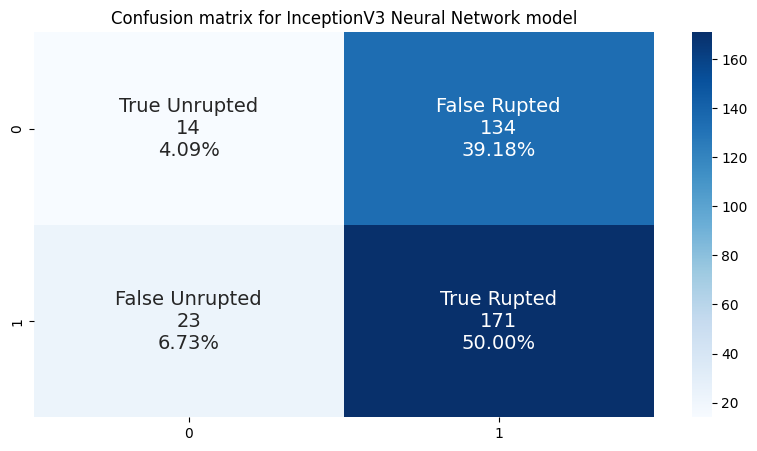

In [83]:
# create CONFUSION MATRIX

cf = confusion_matrix(y_true, pred_classes)
# create labels
group_names = ['True Unrupted','False Rupted','False Unrupted','True Rupted']
group_counts = ["{0:0.0f}".format(value) for value in
                cf.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf.flatten()/np.sum(cf)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(10,5))
palette = sns.color_palette("Blues", as_cmap=True)
sns.heatmap(cf,
            annot=labels,
            fmt='',
            annot_kws={
                'fontsize': 14,
            },
            cmap=palette)
plt.title('Confusion matrix for InceptionV3 Neural Network model')
plt.show()

In [84]:
# evaluate the prediction accuracy
accuracy_test_inceptionV3 = accuracy_score(pred_classes, y_true)
accuracy_test_inceptionV3

0.5409356725146199

## Cross Validation

In [ ]:
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical

In [ ]:
# stratify the dataset into 8 folders
skf = StratifiedKFold(n_splits=8, shuffle = True, random_state=42)

In [ ]:
# convert the Y as dummy
Y = pd.get_dummies(df['Target']).iloc[:, 0].to_numpy()

In [ ]:
# compute CV

# set best accuracy
best_accuracy = 0
# create the list to add the fold accuracies
fold_accuracies_inceptionV2 = []
# set the batch size
batch_size = batch
# set the number of epochs
epoch = n_epoch

for fold_number, (train_index, val_index) in enumerate(skf.split(X, Y), start = 1):
    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = Y[train_index], Y[val_index]

    # perform data augmentation
    datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.1,
    samplewise_std_normalization = True,
    brightness_range = [0.1, 0.5])

    # convert y_train_fold and y_val_fold to one-hot encoded form
    y_train_fold_encoded = to_categorical(y_train_fold, num_classes=2, dtype= 'int')
    y_val_fold_encoded = to_categorical(y_val_fold, num_classes=2, dtype= 'int')

    # set the checkpoint
    checkpoint = ModelCheckpoint(f'bestCV_inceptionV3_{fold_number}.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

    # early stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    # fit the model
    model.fit(
        datagen.flow(X_train_fold, y_train_fold_encoded, batch_size=batch_size),
        steps_per_epoch=len(X_train_fold) // batch_size,
        epochs=epoch,
        validation_data=(X_val_fold, y_val_fold_encoded),
        callbacks = [checkpoint, early_stopping]
    )

    # evaluate the accuracy
    results = model.evaluate(X_val_fold, y_val_fold_encoded)
    # append the accuracies to the list
    fold_accuracy = results[1]
    fold_accuracies_inceptionV2.append(fold_accuracy)

    # compute the best accuracy
    if fold_accuracy > best_accuracy:
        best_accuracy = fold_accuracy
        model.save('bestCV_inceptionV3.h5')

# see results
print("Fold Accuracies:", fold_accuracies_inceptionV2)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1469: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn(


 9/10 [==========================>...] - ETA: 0s - loss: 102.2424 - accuracy: 0.4848
Epoch 1: val_loss improved from inf to 2398.15894, saving model to bestCV_inceptionV3_1.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 21s 2s/step - loss: 97.4099 - accuracy: 0.5000 - val_loss: 2398.1589 - val_accuracy: 0.4167
Epoch 2/50
10/10 [==============================] - ETA: 0s - loss: 79.6649 - accuracy: 0.4595
Epoch 2: val_loss improved from 2398.15894 to 1558.57520, saving model to bestCV_inceptionV3_1.h5
10/10 [==============================] - 9s 914ms/step - loss: 79.6649 - accuracy: 0.4595 - val_loss: 1558.5752 - val_accuracy: 0.4167
Epoch 3/50
10/10 [==============================] - ETA: 0s - loss: 56.2947 - accuracy: 0.4730
Epoch 3: val_loss improved from 1558.57520 to 1371.54016, saving model to bestCV_inceptionV3_1.h5
10/10 [==============================] - 3s 278ms/step - loss: 56.2947 - accuracy: 0.4730 - val_loss: 1371.5402 - val_accuracy: 0.4167
Epoch 4/50
10/10 [==============================] - ETA: 0s - loss: 27.8210 - accuracy: 0.5135
Epoch 4: val_loss improved from 1371.54016 to 705.61700, saving model to bestCV_inceptionV3_1.h5
10/10 [============

In [ ]:
# obtain the CV mean accuracy:
cv_mean_inceptionV3 = np.mean(fold_accuracies_inceptionV2)
cv_max_inceptionV3 = max(fold_accuracies_inceptionV2)
print('Mean CV: ', cv_mean_inceptionV3, '\nMax CV: ', cv_max_inceptionV3)

Mean CV:  0.5426136329770088 
Max CV:  0.5833333134651184


# InceptionResNetV2

Sixth Architecture.

In [85]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input

In [86]:
# upload the base model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [87]:
# freeze the weights
for layer in base_model.layers:
    layer.trainable = False

In [88]:
# create the X array and the dummy variable Y
Y = pd.get_dummies(df['Target']).values
X = df['image_array'].to_numpy()
X = np.concatenate(X, axis = 0)

In [89]:
# build the architecture with base model InceptionResNetV2
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

## Train and Test

In [90]:
# split train / test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)
# split train / validation
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.3, random_state = 42)

In [91]:
# see the shapes
print(f'X shape: {X_val.shape}  Y shape: {Y_val.shape}')

X shape: (410, 224, 224, 3)  Y shape: (410, 2)


Data Augmentation:

In [92]:
# perform data augmentation to avoid overfitting and increase dataset size

datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.1,
    samplewise_std_normalization = True,
    brightness_range = [0.1, 0.5]
)

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1469: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn(


Fit:

In [93]:
# set up batch size and number of epochs
batch_size = batch
epochs = n_epoch

# checkpoint
checkpoint = ModelCheckpoint(f'best_InceptionResnet_traintest.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min') # save the model with the lowest validation loss

# early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# fit the model
model.fit(
    datagen.flow(X_train, Y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=(X_val, Y_val),
    callbacks = [checkpoint, early_stopping]
)

Epoch 1/50
14/14 [==============================] - ETA: 0s - loss: 64.2703 - accuracy: 0.5225
Epoch 1: val_loss improved from inf to 14.23984, saving model to best_InceptionResnet_traintest.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 31s 2s/step - loss: 64.2703 - accuracy: 0.5225 - val_loss: 14.2398 - val_accuracy: 0.4537
Epoch 2/50
14/14 [==============================] - ETA: 0s - loss: 1.4041 - accuracy: 0.5438
Epoch 2: val_loss did not improve from 14.23984
14/14 [==============================] - 15s 1s/step - loss: 1.4041 - accuracy: 0.5438 - val_loss: 26.5216 - val_accuracy: 0.5463
Epoch 3/50
14/14 [==============================] - ETA: 0s - loss: 0.7263 - accuracy: 0.5416
Epoch 3: val_loss improved from 14.23984 to 0.71090, saving model to best_InceptionResnet_traintest.h5
14/14 [==============================] - 22s 2s/step - loss: 0.7263 - accuracy: 0.5416 - val_loss: 0.7109 - val_accuracy: 0.5463
Epoch 4/50
14/14 [==============================] - ETA: 0s - loss: 0.6973 - accuracy: 0.5483
Epoch 4: val_loss improved from 0.71090 to 0.71067, saving model to best_InceptionResnet_traintest.h5
14/14 [==============================] - 25s 2s/step - loss: 0.6973 - accur

In [94]:
# see the accuracy on validation set of the best and saved model
res = model.evaluate(X_val, Y_val)
accuracy_inceptionResnetV2 = res[1]

13/13 [==============================] - 1s 66ms/step - loss: 0.7105 - accuracy: 0.5463


Model Predictions:

In [95]:
# predictions
predictions = model.predict(X_test)
pred_classes = np.argmax(predictions, axis = 1)
y_true = np.argmax(Y_test, axis = 1)

11/11 [==============================] - 2s 62ms/step


Confusion Matrix:

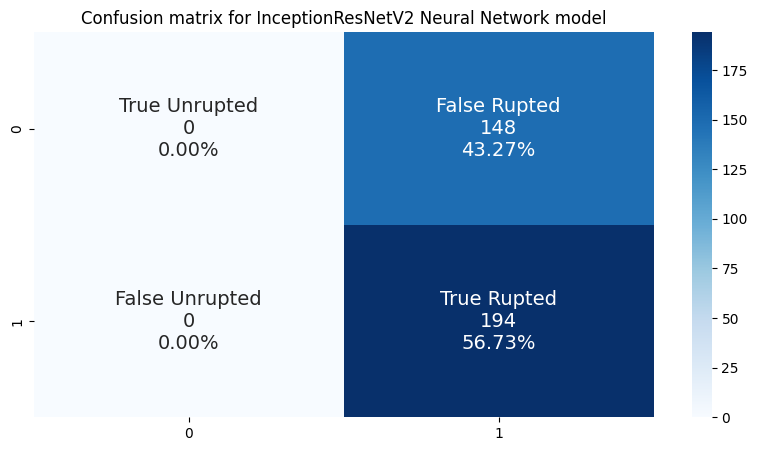

In [96]:
# create CONFUSION MATRIX

cf = confusion_matrix(y_true, pred_classes)
# create labels
group_names = ['True Unrupted','False Rupted','False Unrupted','True Rupted']
group_counts = ["{0:0.0f}".format(value) for value in
                cf.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf.flatten()/np.sum(cf)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(10,5))
palette = sns.color_palette("Blues", as_cmap=True)
sns.heatmap(cf,
            annot=labels,
            fmt='',
            annot_kws={
                'fontsize': 14,
            },
            cmap=palette)
plt.title('Confusion matrix for InceptionResNetV2 Neural Network model')
plt.show()

In [98]:
# evaluate prediction accuracy
accuracy_test_inceptionResnetV2 = accuracy_score(pred_classes, y_true)
accuracy_test_inceptionResnetV2

0.5672514619883041

## Cross Validation

In [ ]:
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical

In [ ]:
# stratify the dataset into 8 folders
skf = StratifiedKFold(n_splits=8, shuffle = True, random_state=42)

In [ ]:
# convert the Y as dummy
Y = pd.get_dummies(df['Target']).iloc[:, 0].to_numpy()

In [ ]:
# compute CV

# set best accuracy
best_accuracy = 0
# create the list to append the accuracies
fold_accuracies_inceptionResnet = []
# set the batch size
batch_size = batch
# set the number of epochs
epoch = n_epoch

for fold_number, (train_index, val_index) in enumerate(skf.split(X, Y), start = 1):
    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = Y[train_index], Y[val_index]

    # perform data augmentation
    datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.1,
    samplewise_std_normalization = True,
    brightness_range = [0.1, 0.5])

    # convert y_train_fold and y_val_fold to one-hot encoded form
    y_train_fold_encoded = to_categorical(y_train_fold, num_classes=2, dtype= 'int')
    y_val_fold_encoded = to_categorical(y_val_fold, num_classes=2, dtype= 'int')

    # set the checkpoint
    checkpoint = ModelCheckpoint(f'bestCV_InceptionResnet_{fold_number}.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

    # early stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    # fit the model
    model.fit(
        datagen.flow(X_train_fold, y_train_fold_encoded, batch_size=batch_size),
        steps_per_epoch=len(X_train_fold) // batch_size,
        epochs=epoch,
        validation_data=(X_val_fold, y_val_fold_encoded),
        callbacks = [checkpoint, early_stopping]
    )

    # evaluate accuracy
    results = model.evaluate(X_val_fold, y_val_fold_encoded)
    # append the accuracy to the list
    fold_accuracy = results[1]
    fold_accuracies_inceptionResnet.append(fold_accuracy)

    # compute the best accuracy
    if fold_accuracy > best_accuracy:
        best_accuracy = fold_accuracy
        model.save('bestCV_InceptionResnet.h5')

# see results
print("Fold Accuracies:", fold_accuracies_inceptionResnet)

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1469: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn(


Epoch 1/50
 9/10 [==========================>...] - ETA: 0s - loss: 98.6302 - accuracy: 0.5556 
Epoch 1: val_loss improved from inf to 563.40741, saving model to bestCV_InceptionResnet_1.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 10s 454ms/step - loss: 100.1719 - accuracy: 0.5541 - val_loss: 563.4074 - val_accuracy: 0.5833
Epoch 2/50
10/10 [==============================] - ETA: 0s - loss: 66.7226 - accuracy: 0.5135
Epoch 2: val_loss did not improve from 563.40741
10/10 [==============================] - 1s 131ms/step - loss: 66.7226 - accuracy: 0.5135 - val_loss: 1848.9945 - val_accuracy: 0.5833
Epoch 3/50
10/10 [==============================] - ETA: 0s - loss: 65.0889 - accuracy: 0.5270
Epoch 3: val_loss did not improve from 563.40741
10/10 [==============================] - 2s 220ms/step - loss: 65.0889 - accuracy: 0.5270 - val_loss: 2224.2451 - val_accuracy: 0.5833
Epoch 4/50
10/10 [==============================] - ETA: 0s - loss: 29.2729 - accuracy: 0.6351
Epoch 4: val_loss improved from 563.40741 to 338.28555, saving model to bestCV_InceptionResnet_1.h5
10/10 [==============================] - 4s 368ms/step - loss: 29.2729 - accuracy: 0.6351 - val_loss: 338.2856 

In [ ]:
# obtain the CV mean accuracy:
cv_mean_InceptionResnet = np.mean(fold_accuracies_inceptionResnet)
cv_max_InceptionResnet = max(fold_accuracies_inceptionResnet)
print('Mean CV: ', cv_mean_InceptionResnet, '\nMax CV: ', cv_max_InceptionResnet)

Mean CV:  0.5426136329770088 
Max CV:  0.5833333134651184


# Xception

In [99]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input

In [100]:
# upload the base model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [101]:
# freeze the weights
for layer in base_model.layers:
    layer.trainable = False

In [102]:
# create the X array and the Y dummy variable
Y = pd.get_dummies(df['Target']).values
X = df['image_array'].to_numpy()
X = np.concatenate(X, axis = 0)

In [103]:
# build the architecture with base model Xception
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

## Train and Test:

In [104]:
# split train / test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)
# split train / validation
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.3, random_state = 42)

In [105]:
# see the shapes
print(f'X shape: {X_val.shape}  Y shape: {Y_val.shape}')

X shape: (410, 224, 224, 3)  Y shape: (410, 2)


Data Augmentation:

In [106]:
# perform data augmentation to avoid overfitting and increase dataset size

datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.1,
    samplewise_std_normalization = True,
    brightness_range = [0.1, 0.5]
)

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1469: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn(


Fit:

In [107]:
# set up batch size and number of epochs
batch_size = batch
epochs = n_epoch

# checkpoint
checkpoint = ModelCheckpoint(f'best_xception.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# fit the model
model.fit(
    datagen.flow(X_train, Y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=(X_val, Y_val),
    callbacks = [checkpoint, early_stopping]
)

Epoch 1/50
14/14 [==============================] - ETA: 0s - loss: 63.7291 - accuracy: 0.5202
Epoch 1: val_loss improved from inf to 385.89645, saving model to best_xception.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 32s 2s/step - loss: 63.7291 - accuracy: 0.5202 - val_loss: 385.8965 - val_accuracy: 0.4537
Epoch 2/50
14/14 [==============================] - ETA: 0s - loss: 2.0420 - accuracy: 0.4876
Epoch 2: val_loss improved from 385.89645 to 0.95012, saving model to best_xception.h5
14/14 [==============================] - 24s 2s/step - loss: 2.0420 - accuracy: 0.4876 - val_loss: 0.9501 - val_accuracy: 0.5244
Epoch 3/50
14/14 [==============================] - ETA: 0s - loss: 0.9259 - accuracy: 0.5461
Epoch 3: val_loss improved from 0.95012 to 0.78158, saving model to best_xception.h5
14/14 [==============================] - 23s 2s/step - loss: 0.9259 - accuracy: 0.5461 - val_loss: 0.7816 - val_accuracy: 0.5390
Epoch 4/50
14/14 [==============================] - ETA: 0s - loss: 0.6913 - accuracy: 0.5483
Epoch 4: val_loss did not improve from 0.78158
14/14 [==============================] - 15s 1s/step - loss: 0.6913 - accuracy: 0.5483 - val_loss: 0.7832 - v

In [108]:
# see the accuracy on validation set of the best and saved model
res = model.evaluate(X_val, Y_val)
accuracy_xception = res[1]

13/13 [==============================] - 1s 66ms/step - loss: 0.6913 - accuracy: 0.5488


Model Predictions:

In [109]:
# predictions
predictions = model.predict(X_test)
pred_classes = np.argmax(predictions, axis = 1)
y_true = np.argmax(Y_test, axis = 1)

11/11 [==============================] - 2s 61ms/step


Confusion Matrix:

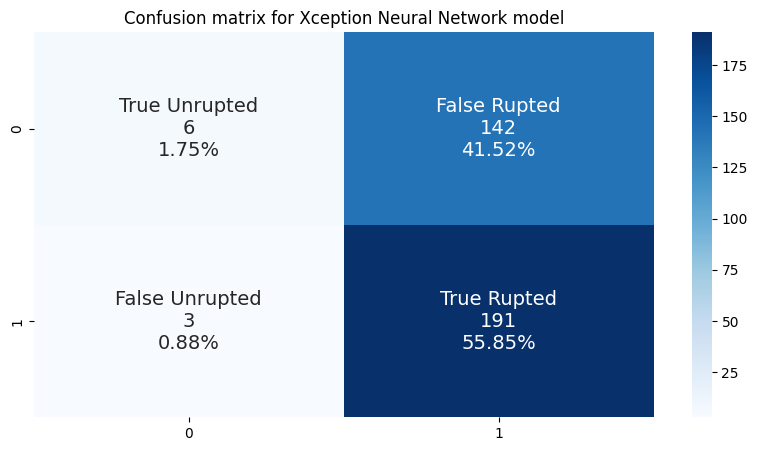

In [110]:
# create CONFUSION MATRIX

cf = confusion_matrix(y_true, pred_classes)
# create labels
group_names = ['True Unrupted','False Rupted','False Unrupted','True Rupted']
group_counts = ["{0:0.0f}".format(value) for value in
                cf.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf.flatten()/np.sum(cf)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(10,5))
palette = sns.color_palette("Blues", as_cmap=True)
sns.heatmap(cf,
            annot=labels,
            fmt='',
            annot_kws={
                'fontsize': 14,
            },
            cmap=palette)
plt.title('Confusion matrix for Xception Neural Network model')
plt.show()

In [112]:
# check prediction accuracy
accuracy_test_xception = accuracy_score(pred_classes, y_true)
accuracy_test_xception

0.5760233918128655

## Cross Validation

In [ ]:
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical

In [ ]:
# stratify the dataset into 8 folders
skf = StratifiedKFold(n_splits=8, shuffle = True, random_state=42)

In [ ]:
# convert the Y as dummy
Y = pd.get_dummies(df['Target']).iloc[:, 0].to_numpy()

In [ ]:
# compute CV

# set best accuracy
best_accuracy = 0
# create the accuracies list
fold_accuracies_xception = []
# set the batch size
batch_size = batch
# set the number of epochs
epoch = n_epoch

for fold_number, (train_index, val_index) in enumerate(skf.split(X, Y), start = 1):
    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = Y[train_index], Y[val_index]

    # perform data augmentation
    datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.1,
    samplewise_std_normalization = True,
    brightness_range = [0.1, 0.5])

    # convert y_train_fold and y_val_fold to one-hot encoded form
    y_train_fold_encoded = to_categorical(y_train_fold, num_classes=2, dtype= 'int')
    y_val_fold_encoded = to_categorical(y_val_fold, num_classes=2, dtype= 'int')

    # set the checkpoint
    checkpoint = ModelCheckpoint(f'bestCV_xception_{fold_number}.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

    # early stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    # fit the model
    model.fit(
        datagen.flow(X_train_fold, y_train_fold_encoded, batch_size=batch_size),
        steps_per_epoch=len(X_train_fold) // batch_size,
        epochs=epoch,
        validation_data=(X_val_fold, y_val_fold_encoded),
        callbacks = [checkpoint, early_stopping]
    )

    # evaluate accuracy
    results = model.evaluate(X_val_fold, y_val_fold_encoded)
    # append accuracies to the list
    fold_accuracy = results[1]
    fold_accuracies_xception.append(fold_accuracy)

    # compute best accuracy
    if fold_accuracy > best_accuracy:
        best_accuracy = fold_accuracy
        model.save('bestCV_xception.h5')

# see results
print("Fold Accuracies:", fold_accuracies_xception)

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1469: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn(


Epoch 1/50
10/10 [==============================] - ETA: 0s - loss: 76.7584 - accuracy: 0.5405
Epoch 1: val_loss improved from inf to 1478.18152, saving model to bestCV_xception_1.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 17s 942ms/step - loss: 76.7584 - accuracy: 0.5405 - val_loss: 1478.1815 - val_accuracy: 0.4167
Epoch 2/50
10/10 [==============================] - ETA: 0s - loss: 72.2053 - accuracy: 0.5946
Epoch 2: val_loss did not improve from 1478.18152
10/10 [==============================] - 1s 132ms/step - loss: 72.2053 - accuracy: 0.5946 - val_loss: 1762.3014 - val_accuracy: 0.5833
Epoch 3/50
 9/10 [==========================>...] - ETA: 0s - loss: 51.4678 - accuracy: 0.6250
Epoch 3: val_loss did not improve from 1478.18152
10/10 [==============================] - 1s 130ms/step - loss: 50.2752 - accuracy: 0.6216 - val_loss: 1650.9652 - val_accuracy: 0.4167
Epoch 4/50
10/10 [==============================] - ETA: 0s - loss: 33.5860 - accuracy: 0.5135
Epoch 4: val_loss improved from 1478.18152 to 305.64755, saving model to bestCV_xception_1.h5
10/10 [==============================] - 7s 737ms/step - loss: 33.5860 - accuracy: 0.5135 - val_loss: 305.6476 - va

In [ ]:
# obtain the CV mean accuracy:
cv_mean_Xception = np.mean(fold_accuracies_xception)
cv_max_Xception = max(fold_accuracies_xception)
print('CV Mean: ', cv_mean_Xception, '\nCV Max: ', cv_max_Xception)

CV Mean:  0.5530303046107292 
CV Max:  0.6666666865348816


# Show results

#### CV:

Mean CV Accuracies:

In [ ]:
# print results
print('Mean CV accuracies:\n\n',
      'VGG16: ', cv_mean_vgg16,
      '\nVGG19: ', cv_mean_vgg19,
      '\nResNet50: ', cv_mean_resnet50,
      '\nResNet50V2: ', cv_mean_resnet50V2,
      '\nInceptionV3: ', cv_mean_inceptionV3,
      '\nInceptionResNet: ', cv_mean_InceptionResnet,
      '\nXception: ', cv_mean_Xception)

Mean CV accuracies:

 VGG16:  0.6183712109923363 
VGG19:  0.6392045468091965 
ResNet50:  0.6268939450383186 
ResNet50V2:  0.5530302971601486 
InceptionV3:  0.5426136329770088 
InceptionResNet:  0.5426136329770088 
Xception:  0.5530303046107292


Plot results:

In [ ]:
to_plot = [cv_mean_vgg16, cv_mean_vgg19, cv_mean_resnet50, cv_mean_resnet50V2, cv_mean_inceptionV3, cv_mean_InceptionResnet, cv_mean_Xception]
label = ['VGG16', 'VGG19', 'ResNet50', 'ResNet50V2', 'InceptionV3', 'InceptionResNet', 'Xception']
color = sns.color_palette("Blues")[5]

Text(0.5, 1.0, 'Mean CV accuracies - NN Performance Comparison')

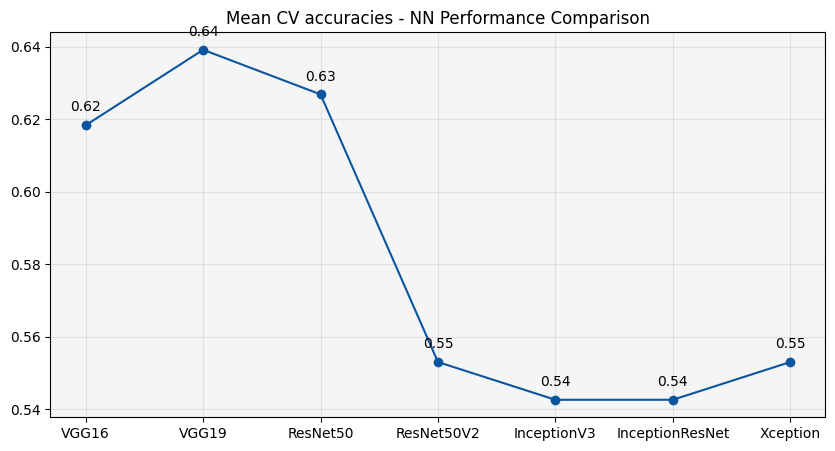

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, 8), to_plot, '-o', color = color)
plt.grid(True, linestyle='-', alpha=0.3)
plt.gca().set_facecolor('whitesmoke')
plt.xticks(np.arange(1, 8), label)
for i, name in enumerate(label):
    plt.annotate(f'{to_plot[i]:.2}', (i + 1, to_plot[i]), textcoords="offset points", xytext=(0, 10), ha='center')
plt.title('Mean CV accuracies - NN Performance Comparison')

Max CV Accuracy:

In [ ]:
print('Max CV accuracies:\n\n',
      'VGG16: ', cv_max_vgg16,
      '\nVGG19: ', cv_max_vgg19,
      '\nResNet50: ', cv_max_resnet50,
      '\nResNet50V2: ', cv_max_resnet50V2,
      '\nInceptionV3: ', cv_max_inceptionV3,
      '\nInceptionResNet: ', cv_max_InceptionResnet,
      '\nXception: ', cv_max_Xception)

Max CV accuracies:

 VGG16:  0.7272727489471436 
VGG19:  0.7272727489471436 
ResNet50:  0.8333333134651184 
ResNet50V2:  0.5833333134651184 
InceptionV3:  0.5833333134651184 
InceptionResNet:  0.5833333134651184 
Xception:  0.6666666865348816


Plot results:

In [ ]:
to_plot = [cv_max_vgg16, cv_max_vgg19, cv_max_resnet50, cv_max_resnet50V2, cv_max_inceptionV3, cv_max_InceptionResnet, cv_max_Xception]
label = ['VGG16', 'VGG19', 'ResNet50', 'ResNet50V2', 'InceptionV3', 'InceptionResNet', 'Xception']
color = sns.color_palette("Blues")[5]

Text(0.5, 1.0, 'Max CV accuracies - NN Performance Comparison')

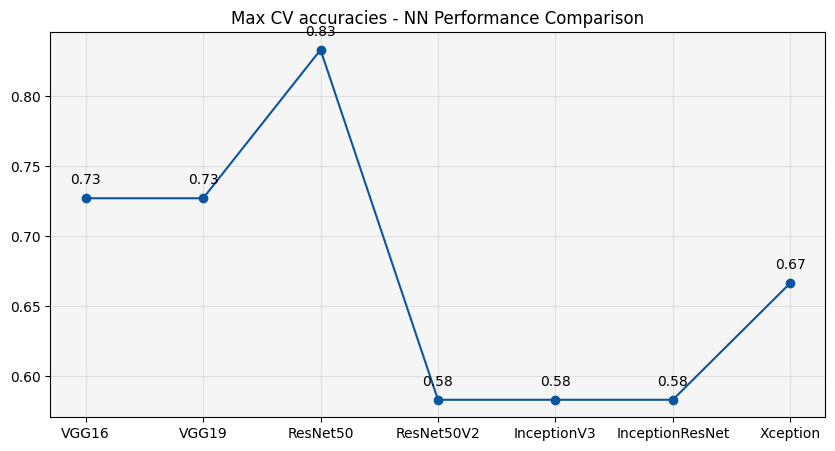

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, 8), to_plot, '-o', color = color)
plt.grid(True, linestyle='-', alpha=0.3)
plt.gca().set_facecolor('whitesmoke')
plt.xticks(np.arange(1, 8), label)
for i, name in enumerate(label):
    plt.annotate(f'{to_plot[i]:.2}', (i + 1, to_plot[i]), textcoords="offset points", xytext=(0, 10), ha='center')
plt.title('Max CV accuracies - NN Performance Comparison')

Overall Performance Trend:

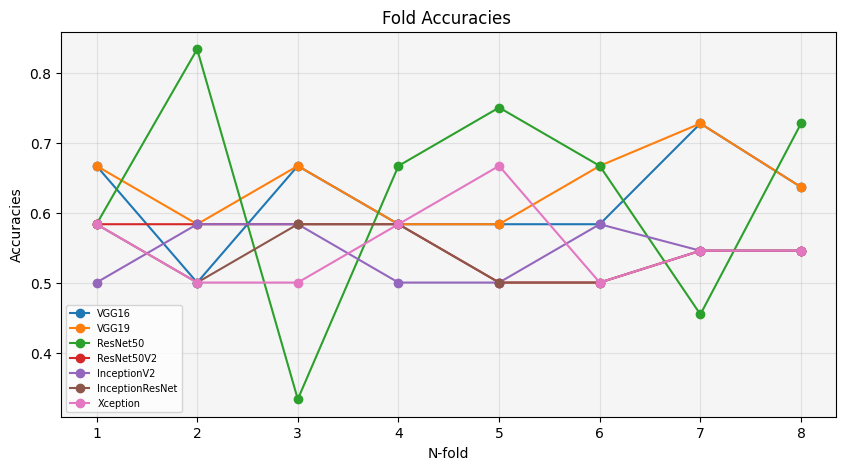

In [ ]:
x = np.arange(1,9)
plt.figure(figsize=(10, 5))
plt.plot(x, fold_accuracies_vgg16, '-o', label = 'VGG16')
plt.plot(x, fold_accuracies_vgg19, '-o', label = 'VGG19')
plt.plot(x, fold_accuracies_resnet50, '-o', label = 'ResNet50')
plt.plot(x, fold_accuracies_resnetV2, '-o', label = 'ResNet50V2')
plt.plot(x, fold_accuracies_inceptionV2, '-o', label = 'InceptionV2')
plt.plot(x, fold_accuracies_inceptionResnet, '-o', label = 'InceptionResNet')
plt.plot(x, fold_accuracies_xception, '-o', label = 'Xception')

plt.grid(True, linestyle='-', alpha=0.3)
plt.gca().set_facecolor('whitesmoke')

plt.xlabel('N-fold')
plt.ylabel('Accuracies')
plt.title('Fold Accuracies ')

plt.legend(fontsize = 7)

#### Train and Test

Evaluate Validation Accuracies:

In [113]:
print('Mean CV accuracies:\n\n',
      'VGG16: ', accuracy_vgg16,
      '\nVGG19: ', accuracy_vgg19,
      '\nResNet50: ', accuracy_resnet50,
      '\nResNet50V2: ', accuracy_resnetv2,
      '\nInceptionV3: ', accuracy_inceptionv3,
      '\nInceptionResNet: ', accuracy_inceptionResnetV2,
      '\nXception: ', accuracy_xception)

Mean CV accuracies:

 VGG16:  0.6097561120986938 
VGG19:  0.6247288584709167 
ResNet50:  0.5780487656593323 
ResNet50V2:  0.5463414788246155 
InceptionV3:  0.5414634346961975 
InceptionResNet:  0.5463414788246155 
Xception:  0.5487805008888245


Plot Results:

In [114]:
to_plot = [accuracy_vgg16, accuracy_vgg19, accuracy_resnet50, accuracy_resnetv2, accuracy_inceptionv3, accuracy_inceptionResnetV2, accuracy_xception]
label = ['VGG16', 'VGG19', 'ResNet50', 'ResNet50V2', 'InceptionV3', 'InceptionResNet', 'Xception']
color = sns.color_palette("Blues")[5]

Text(0.5, 1.0, 'Validation accuracies - NN Performance Comparison')

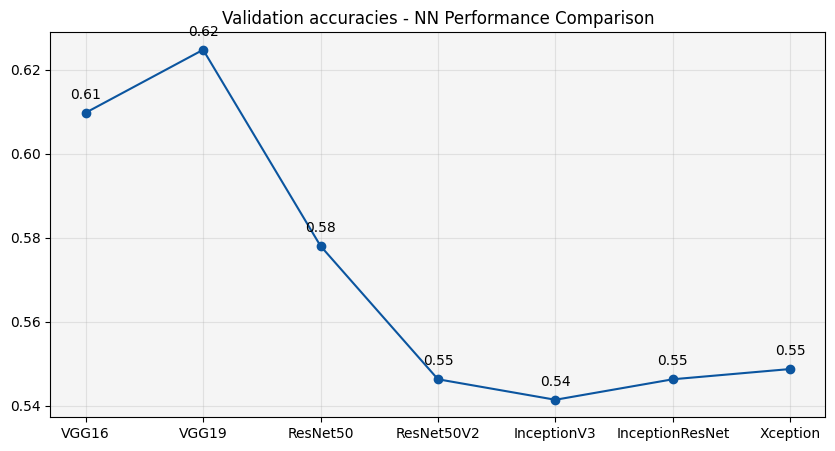

In [115]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, 8), to_plot, '-o', color = color)
plt.grid(True, linestyle='-', alpha=0.3)
plt.gca().set_facecolor('whitesmoke')
plt.xticks(np.arange(1, 8), label)
for i, name in enumerate(label):
    plt.annotate(f'{to_plot[i]:.2}', (i + 1, to_plot[i]), textcoords="offset points", xytext=(0, 10), ha='center')
plt.title('Validation accuracies - NN Performance Comparison')

Evaluate Test (Prediction) Accuracies:

In [116]:
print('Mean CV accuracies:\n\n',
      'VGG16: ', accuracy_test_vgg16,
      '\nVGG19: ', accuracy_test_vgg19,
      '\nResNet50: ', accuracy_test_resnet50,
      '\nResNet50V2: ', accuracy_test_resnet50V2,
      '\nInceptionV3: ', accuracy_test_inceptionV3,
      '\nInceptionResNet: ', accuracy_test_inceptionResnetV2,
      '\nXception: ', accuracy_test_xception)

Mean CV accuracies:

 VGG16:  0.6228070175438597 
VGG19:  0.5906432748538012 
ResNet50:  0.5497076023391813 
ResNet50V2:  0.5672514619883041 
InceptionV3:  0.5409356725146199 
InceptionResNet:  0.5672514619883041 
Xception:  0.5760233918128655


Plot Resuls:

In [117]:
to_plot = [accuracy_test_vgg16, accuracy_test_vgg19, accuracy_test_resnet50, accuracy_test_resnet50V2, accuracy_test_inceptionV3, accuracy_test_inceptionResnetV2, accuracy_test_xception]
label = ['VGG16', 'VGG19', 'ResNet50', 'ResNet50V2', 'InceptionV3', 'InceptionResNet', 'Xception']
color = sns.color_palette("Blues")[5]

Text(0.5, 1.0, 'Test accuracies - NN Performance Comparison')

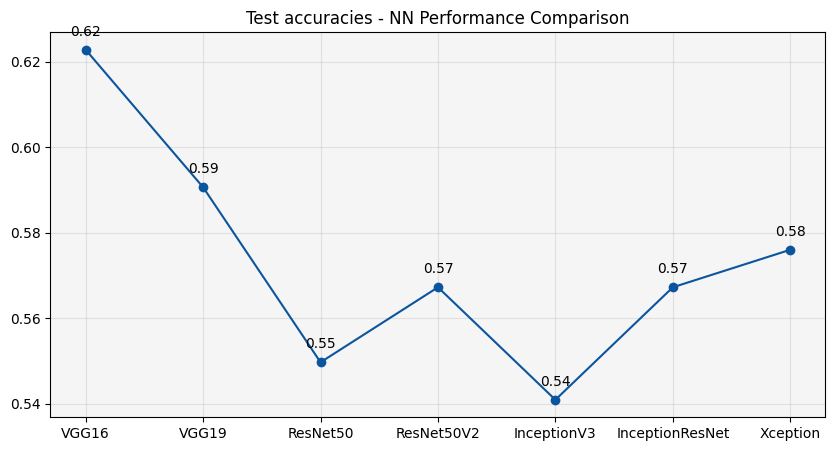

In [118]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, 8), to_plot, '-o', color = color)
plt.grid(True, linestyle='-', alpha=0.3)
plt.gca().set_facecolor('whitesmoke')
plt.xticks(np.arange(1, 8), label)
for i, name in enumerate(label):
    plt.annotate(f'{to_plot[i]:.2}', (i + 1, to_plot[i]), textcoords="offset points", xytext=(0, 10), ha='center')
plt.title('Test accuracies - NN Performance Comparison')